In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster( walltime='3:00:00')
#w = cluster.scale(5*14)
w = cluster.scale(1*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.147:38716 Dashboard: http://10.148.0.147:8787/status,Cluster Workers: 20 Cores: 80 Memory: 1000.00 GB


---


# 1. Drifter data files

In [5]:
# The processed data set includes both Argos- and GPS-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [7]:
# turn mean-lon into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [8]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [9]:
# (u,v) --> u+iv
uv = np.array(drifter_dataset['uv2']).view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [10]:
# Drifter Dataset (u+iv,lat,lon,time,qd)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...

 data size: 3.6 GB


_________
# 2. Rotary spectra of Drifter velocities (u+iv) for the North Atlantic domain (lon=[-97,41], lat=[7,62])

## 2.1. Zonally averaged rotary spectra

In [11]:
# Linear detrending and Hanning windowing

uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat>7) & (ds.lat<62) & ((ds.lon>263) & (ds.lon<360) | (ds.lon>0) & (ds.lon<41))).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonal_mean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_uv_zonal_mean = np.real(E_uv_zonal_mean).rename('E_uv_zonal_mean')
file_E = data_dir+'E_drifter_zonal_mean_NA.zarr'
%time E_uv_zonal_mean.to_dataset().to_zarr(file_E, mode='w')  

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.0.147:34114 remote=tcp://10.148.0.147:38716>


CPU times: user 4.58 s, sys: 300 ms, total: 4.88 s
Wall time: 474 ms


In [12]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
E_uv_zonal_mean = xr.open_zarr(data_dir+'E_drifter_zonal_mean_NA.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_uv_zonal_mean = E_uv_zonal_mean.E_uv_zonal_mean

Text(0.5,1,'Drifter (North Atlantic)')

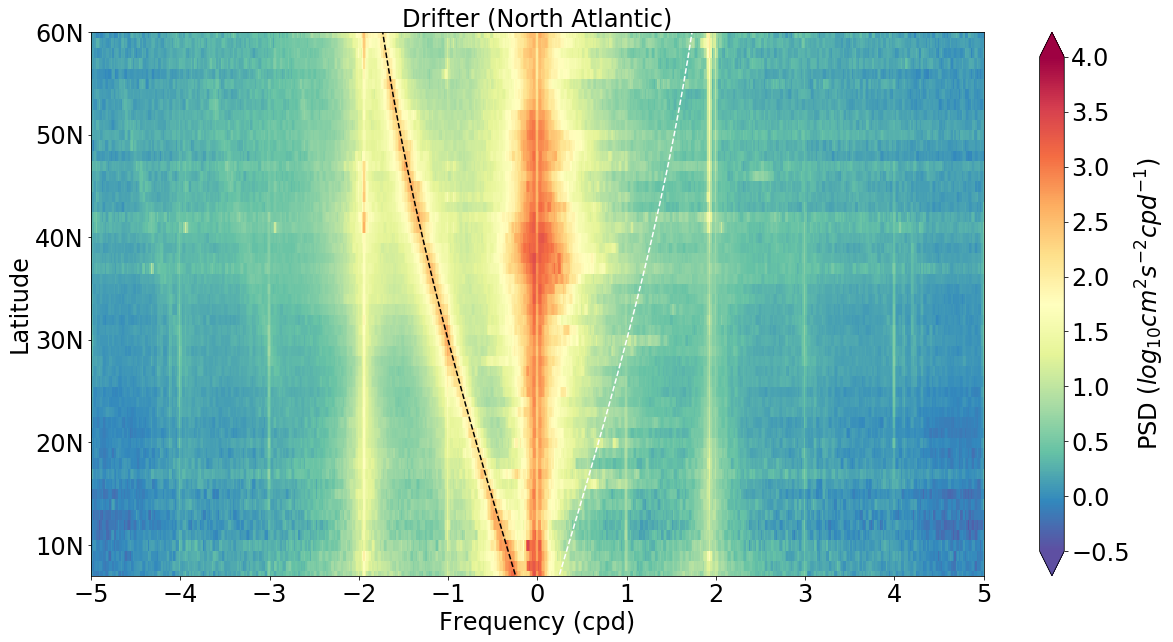

In [14]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)

cax = np.log10(E_uv_zonal_mean.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-0.5, vmax=4, x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)
            
# x,y ticks
#ax.set_xticks([-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
#ax.set_xlim(-12., 12.)
ax.set_xlim(-5., 5.)
ax.set_ylim(7., 60.)
ax.set_yticks([10., 20., 30, 40., 50, 60.])
ax.set_yticklabels(['10N','20N','30N','40N','50N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_uv_zonal_mean.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'k--')
ax.set_title('Drifter (North Atlantic)',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_lat_Drifter.png')


## 2.3. Domain averaged spectra

In [15]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat<62) & (ds.lat>7) & ((ds.lon<360) & (ds.lon>263) | (ds.lon<41) & (ds.lon>0))).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
file_E = data_dir+'E_drifter_uv_qd_blocks_NA.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 1.95 s, sys: 124 ms, total: 2.07 s
Wall time: 17.9 s


In [16]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_blocks = xr.open_zarr(data_dir+'E_drifter_uv_qd_blocks_NA.zarr').chunk({'freq_time': 1440,'lat': 1000}) 
E_uv_blocks = ds_blocks.E_uv_blocks
print(E_uv_blocks)

<xarray.DataArray 'E_uv_blocks' (lat: 157978, freq_time: 1440)>
dask.array<shape=(157978, 1440), dtype=float64, chunksize=(1000, 1440)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat                (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 ...


In [17]:
# The domain is in the Northern Hemisphere, a direct average over latitude is fine to estimte domain-averaged rotary spectra.
E_uv_domain_mean = E_uv_blocks.mean(dim=('lat'))/8.64
E_uv_domain_mean = E_uv_domain_mean.assign_coords(freq_time=E_uv_domain_mean.freq_time * 86400.) 
E_uv_domain_mean = np.real(E_uv_domain_mean).rename('E_uv_domain_mean')
print(E_uv_domain_mean)
file_E = data_dir+'E_drifter_uv_domain_average_NA.zarr'
%time E_uv_domain_mean.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_domain_mean' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
CPU times: user 1.78 s, sys: 100 ms, total: 1.88 s
Wall time: 5.75 s


Text(0.5,1,'Domain-averaged rotary spectra')

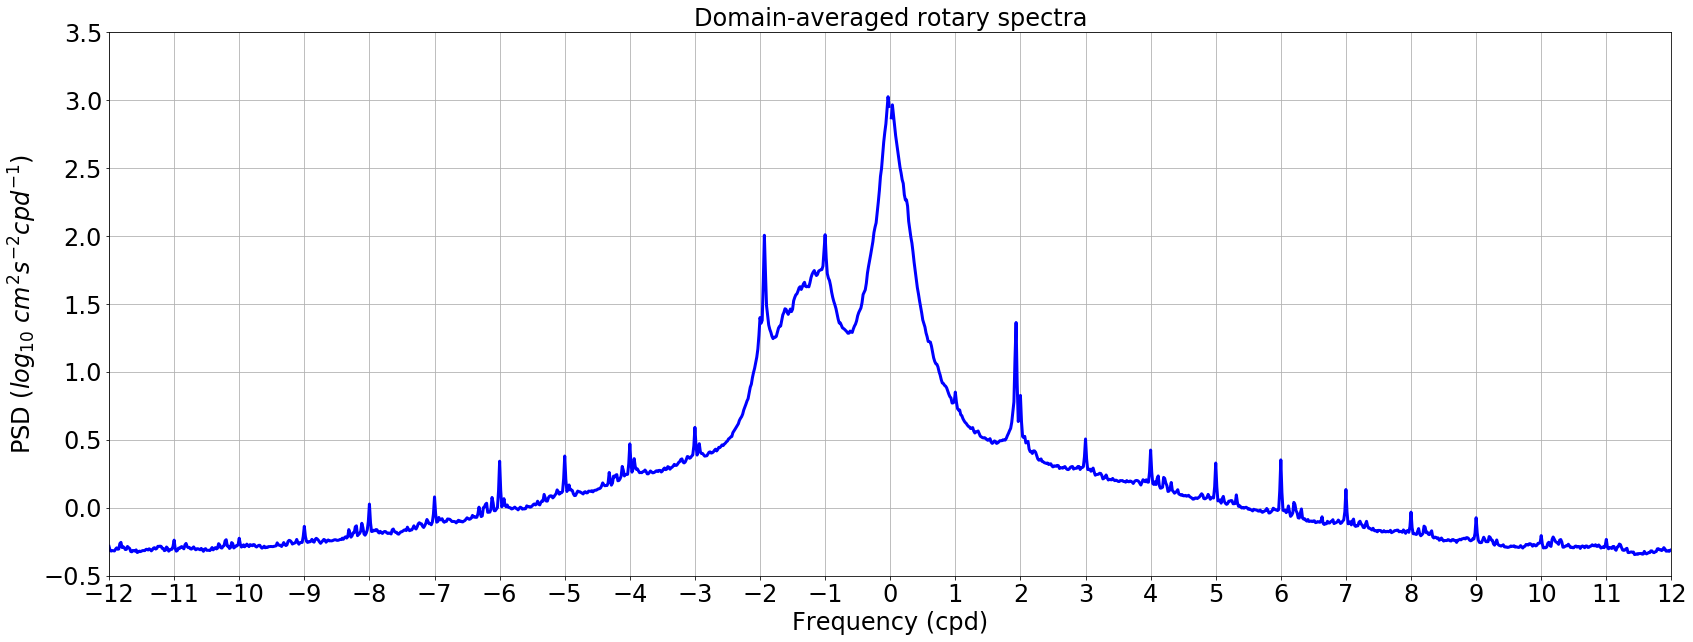

In [18]:
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(1,1,1)
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time>0.).plot(ax=ax, linewidth=3, color='blue')
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time<0.).plot(ax=ax, linewidth=3, color='blue')
ax.grid()
ax.set_ylim([-0.5,3.5])
ax.set_yticks([-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

_________
# 3. Band integrated energies

## raw (no detrending and no windowing), to compute total KE

In [19]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where((ds.qd>0) & (ds.lat>7) & (ds.lat<62) & ((ds.lon>263) & (ds.lon<360) | (ds.lon>0) & (ds.lon<41))).fillna(0.), dim=['time'], shift=False, detrend=False, window=False, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_raw = E_uv_zonmean
E_drifter_raw = np.real(E_drifter_raw).rename('E_drifter_raw')
file_E = data_dir+'E_drifter_raw_NA.zarr'
%time E_drifter_raw.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 4.48 s, sys: 284 ms, total: 4.76 s
Wall time: 200 ms


In [20]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

ds_raw = xr.open_zarr(data_dir+'E_drifter_raw_NA.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_uv_zonal_mean = xr.open_zarr(data_dir+'E_drifter_zonal_mean_NA.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 

E_drifter_raw = ds_raw.E_drifter_raw
E_uv_zonal_mean = E_uv_zonal_mean.E_uv_zonal_mean

In [21]:
df=ds_raw.freq_time[1]-ds_raw.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


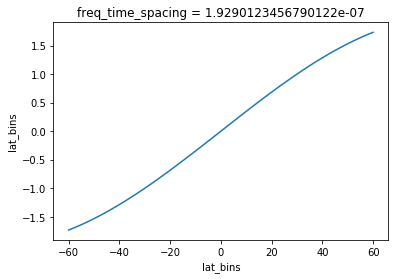

In [22]:
# Inertial frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter_raw.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
f_cpd_drifter.plot()

In [24]:

E_semi = (E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df*8/3).sum(dim='freq_time')
E_semi = np.real(E_semi).rename('E_semi')

E_diurnal = (E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df*8/3).sum(dim='freq_time')
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

E_high = (E_drifter.where((abs(E_drifter.freq_cpd)>=0.5), other=0.)*df*8/3).sum(dim='freq_time')
E_high  = np.real(E_high).rename('E_high')

E_f = (E_drifter.where((abs(E_drifter.freq_cpd+f_cpd_drifter)<0.1), other=0.)*df*8/3).sum(dim='freq_time')
E_f = np.real(E_f).rename('E_f')

E_total = (E_raw*df).sum(dim='freq_time')
E_total  = np.real(E_total).rename('E_total')

E_low = E_total - E_high
E_low  = np.real(E_low).rename('E_low')

In [37]:
E_KE = xr.merge([E_semi.to_dataset(), E_diurnal.to_dataset(), E_high.to_dataset(), E_f.to_dataset(), E_total.to_dataset(), E_low.to_dataset()])
file_E = data_dir+'E_drifter_each_band_NA.nc'
%time E_KE.to_netcdf(file_E, mode='w')  

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


CPU times: user 8.26 s, sys: 476 ms, total: 8.73 s
Wall time: 18.3 s


In [25]:
E_KE = xr.merge([E_semi.to_dataset(), E_diurnal.to_dataset(), E_high.to_dataset(), E_f.to_dataset(), E_total.to_dataset(), E_low.to_dataset()])
file_E = data_dir+'E_drifter_each_band_NA.zarr'
%time E_KE.to_zarr(file_E, mode='w')  

CPU times: user 2.07 s, sys: 132 ms, total: 2.2 s
Wall time: 3 s


In [31]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_each_band = xr.open_zarr(data_dir+'E_drifter_each_band_NA.zarr')
print(ds_each_band)

<xarray.Dataset>
Dimensions:            (lat_bins: 121)
Coordinates:
    freq_time_spacing  float64 ...
  * lat_bins           (lat_bins) int64 -60 -59 -58 -57 -56 -55 -54 -53 -52 ...
Data variables:
    E_diurnal          (lat_bins) float64 dask.array<shape=(121,), chunksize=(1,)>
    E_f                (lat_bins) float64 dask.array<shape=(121,), chunksize=(1,)>
    E_high             (lat_bins) float64 dask.array<shape=(121,), chunksize=(1,)>
    E_low              (lat_bins) float64 dask.array<shape=(121,), chunksize=(1,)>
    E_semi             (lat_bins) float64 dask.array<shape=(121,), chunksize=(1,)>
    E_total            (lat_bins) float64 dask.array<shape=(121,), chunksize=(1,)>


Text(0.5,1,'Drifters')

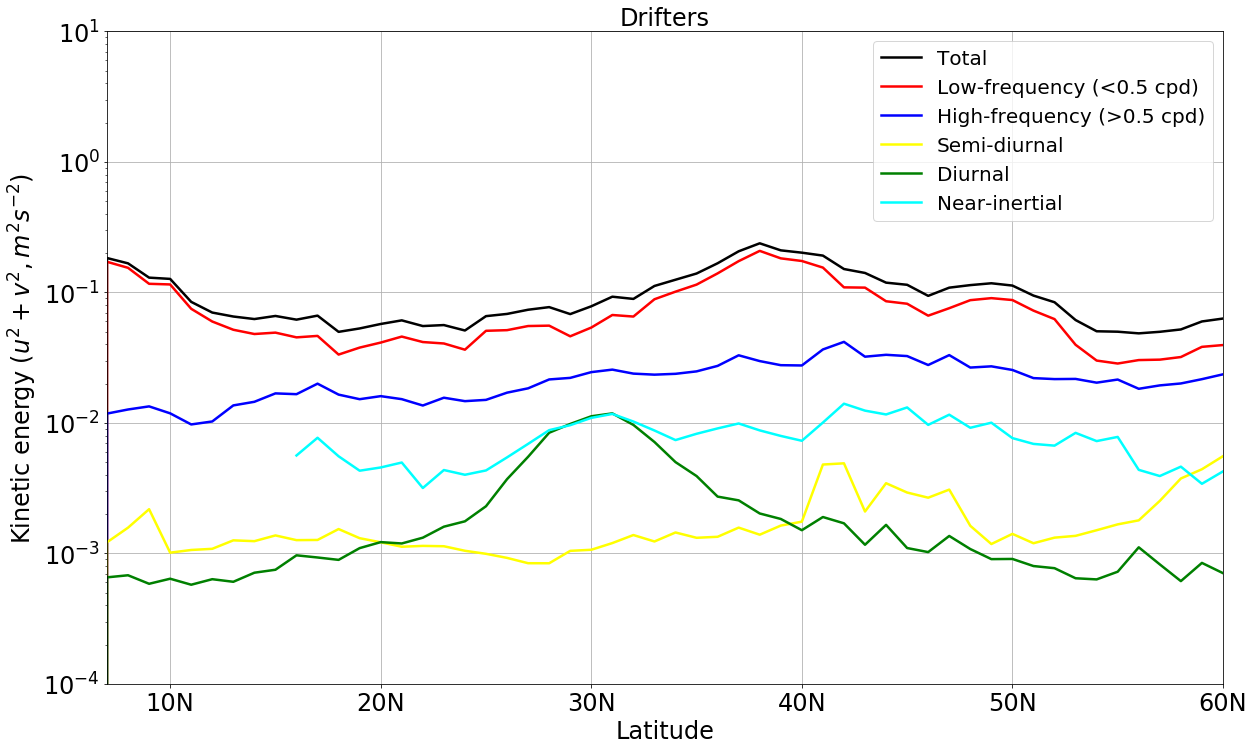

In [32]:
fig, ax = plt.subplots(figsize=(20,12))

labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

ds_each_band.E_total.plot(color='black', label=labels[0], linewidth=2.5) # total energy
(ds_each_band.E_total - ds_each_band.E_high).plot(color='red', label=labels[1], linewidth=2.5) # energy at low frequencies (> 2 day)
ds_each_band.E_high.plot(color='blue', label=labels[2], linewidth=2.5)   # energy at high frequencies (< 2 day)
ds_each_band.E_semi.plot(color='yellow', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
ds_each_band.E_diurnal.plot(color='green', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
ds_each_band.E_f.where(abs(ds_each_band.lat_bins)>15).plot(color='cyan', label=labels[5], linewidth=2.5) # energy around f

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(7., 60.)
ax.set_xticks([10., 20., 30., 40., 50., 60.])
ax.set_xticklabels(['10N','20N','30N','40N','50N','60N'])
#ax.set_ylim([0,0.4])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e1])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters',fontsize=24)

In [1]:
cluster.close()

NameError: name 'cluster' is not defined